# Multiple Linear Regression
This document contains some QM group presentaion parts shown in below:

1. Multiple linear regression - based on the traffic accident data

In the MLP, we only concern the environment factors:
1. weather conditions
1. road conditions
1. light conditions
1. Urban or rural area


时间和日期做聚类
小区域分析

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import numpy as np
import datetime
import time

In [3]:
# load the data
csv = pd.read_csv("./data/dft-road-casualty-statistics-accident-1979-2021.csv")
# csv.info()

C:\Users\29425\AppData\Local\Temp\ipykernel_11152\1176868694.py:2: DtypeWarning: Columns (0,2,15,16,35) have mixed types. Specify dtype option on import or set low_memory=False.
  csv = pd.read_csv("./data/dft-road-casualty-statistics-accident-1979-2021.csv")


In [4]:
csv.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
0,197901A11AD14,1979,01A11AD14,NaN,NaN,NaN,NaN,1,3,2,...,-1,1,8,1,-1,0,-1,-1,-1,-1
1,197901A1BAW34,1979,01A1BAW34,198460.0,894000.0,NaN,NaN,1,3,1,...,-1,4,8,3,-1,0,-1,-1,-1,-1
2,197901A1BFD77,1979,01A1BFD77,406380.0,307000.0,NaN,NaN,1,3,2,...,-1,4,8,3,-1,0,-1,-1,-1,-1
3,197901A1BGC20,1979,01A1BGC20,281680.0,440000.0,NaN,NaN,1,3,2,...,-1,4,8,3,-1,0,-1,-1,-1,-1
4,197901A1BGF95,1979,01A1BGF95,153960.0,795000.0,NaN,NaN,1,2,2,...,-1,4,3,3,-1,0,-1,-1,-1,-1


In [5]:
csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8703911 entries, 0 to 8703910
Data columns (total 36 columns):
 #   Column                                       Dtype  
---  ------                                       -----  
 0   accident_index                               object 
 1   accident_year                                int64  
 2   accident_reference                           object 
 3   location_easting_osgr                        float64
 4   location_northing_osgr                       float64
 5   longitude                                    float64
 6   latitude                                     float64
 7   police_force                                 int64  
 8   accident_severity                            int64  
 9   number_of_vehicles                           int64  
 10  number_of_casualties                         int64  
 11  date                                         object 
 12  day_of_week                                  int64  
 13  time        

In [6]:
csv.columns

Index(['accident_index', 'accident_year', 'accident_reference',
       'location_easting_osgr', 'location_northing_osgr', 'longitude',
       'latitude', 'police_force', 'accident_severity', 'number_of_vehicles',
       'number_of_casualties', 'date', 'day_of_week', 'time',
       'local_authority_district', 'local_authority_ons_district',
       'local_authority_highway', 'first_road_class', 'first_road_number',
       'road_type', 'speed_limit', 'junction_detail', 'junction_control',
       'second_road_class', 'second_road_number',
       'pedestrian_crossing_human_control',
       'pedestrian_crossing_physical_facilities', 'light_conditions',
       'weather_conditions', 'road_surface_conditions',
       'special_conditions_at_site', 'carriageway_hazards',
       'urban_or_rural_area', 'did_police_officer_attend_scene_of_accident',
       'trunk_road_flag', 'lsoa_of_accident_location'],
      dtype='object')

In [7]:
accident_count_by_district = csv.query("accident_year>2015 & local_authority_district != -1").groupby(["local_authority_district"]).size().reset_index(name='accident_counts').sort_values(by=["accident_counts"])
accident_count_by_district

,local_authority_district,accident_counts
371,933,83
374,936,88
379,941,103
35,57,165
353,915,209
...,...,...
300,596,5524
8,9,6142
0,1,7291
94,204,7633


## Test Area

In [8]:
csv["date"]

0          18/01/1979
1          01/01/1979
2          01/01/1979
3          01/01/1979
4          01/01/1979
              ...    
8703906    22/09/2021
8703907    11/09/2021
8703908    17/04/2021
8703909    17/09/2021
8703910    15/10/2021
Name: date, Length: 8703911, dtype: object

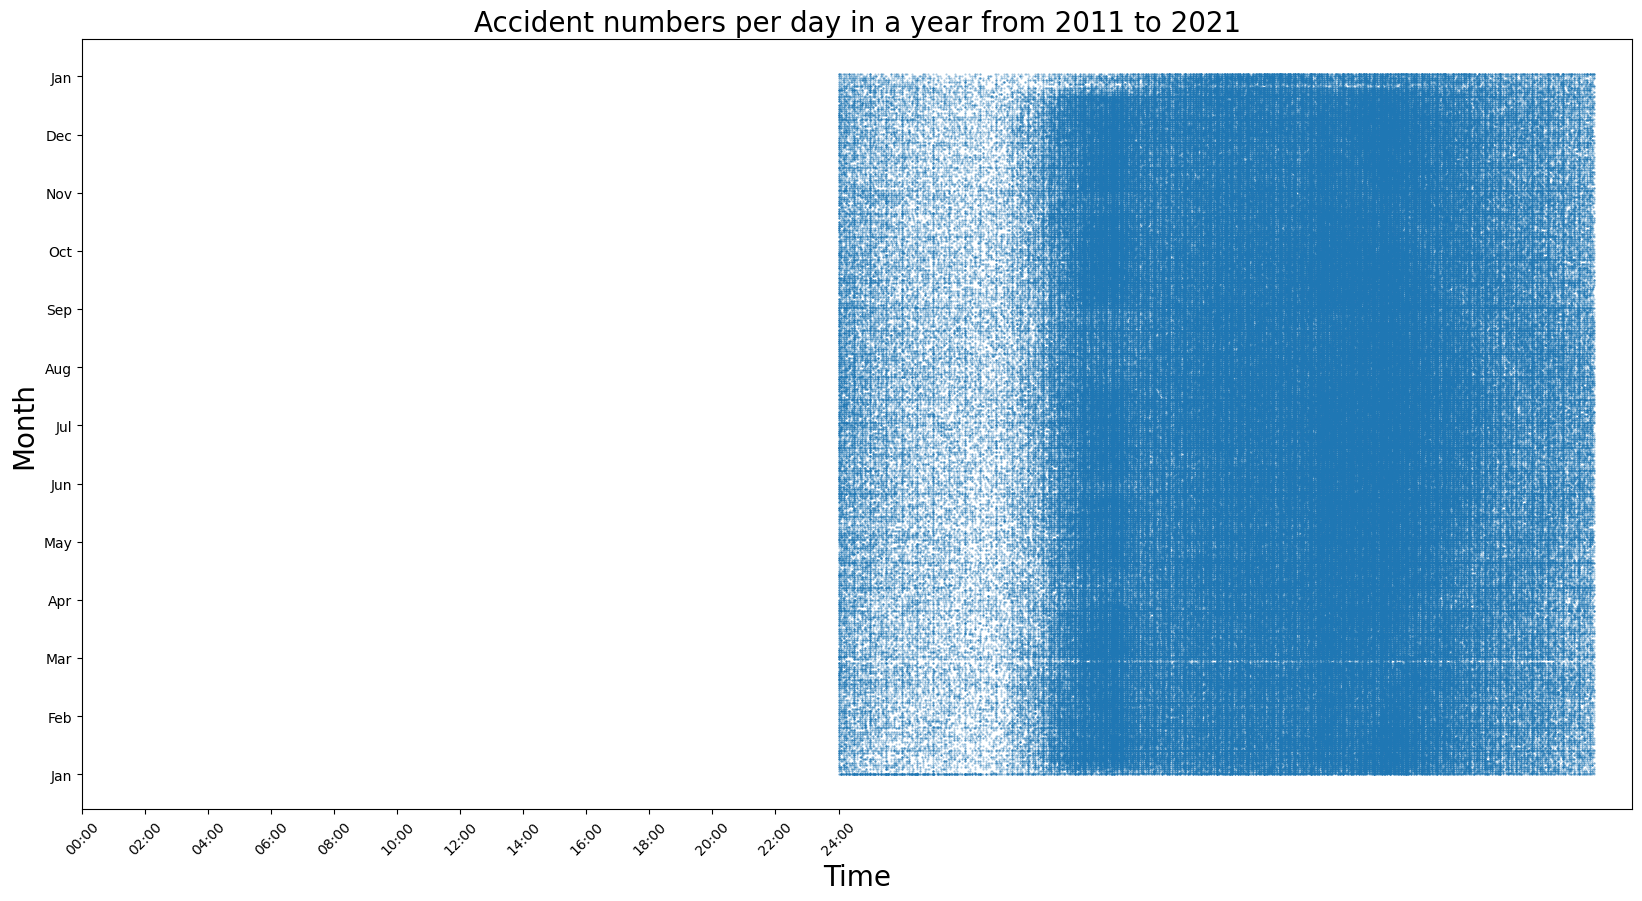

In [9]:
test_csv = csv.query("accident_year > 2010 & weather_conditions == 1 & local_authority_district != -1")[["time", "date"]].reset_index().drop(["index"],axis=1)

test_csv["time"] = pd.to_datetime(test_csv["time"])

test_csv[["date"]] = test_csv[["date"]].astype("string")
test_csv["date"] = test_csv["date"].map(lambda x: str(x)[3:-5]) + "-" + test_csv["date"].map(lambda x: str(x)[0:-8])
# test_csv

sort_csv = test_csv.sort_values(by=["date", "time"]).reset_index().drop(["index"],axis=1)
sort_csv.head()

x_ticks = np.linspace(19334, 19335, 13)
x_labels = ["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00", "24:00"]

y_ticks = np.linspace(0, 364, 13)
y_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec", "Jan"]

plt.figure(figsize=(20, 10), dpi=100)
plt.scatter(sort_csv["time"], sort_csv["date"].astype(str),s=1, marker=".", alpha=0.4,)
# set the style
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Month", fontsize = 20)
plt.xticks(ticks=x_ticks, labels=x_labels, fontsize = 10, rotation = "45")
plt.yticks(ticks=y_ticks, labels=y_labels, fontsize = 10)
plt.title ("Accident numbers per day in a year from 2011 to 2021", fontsize = 20)

plt.show()

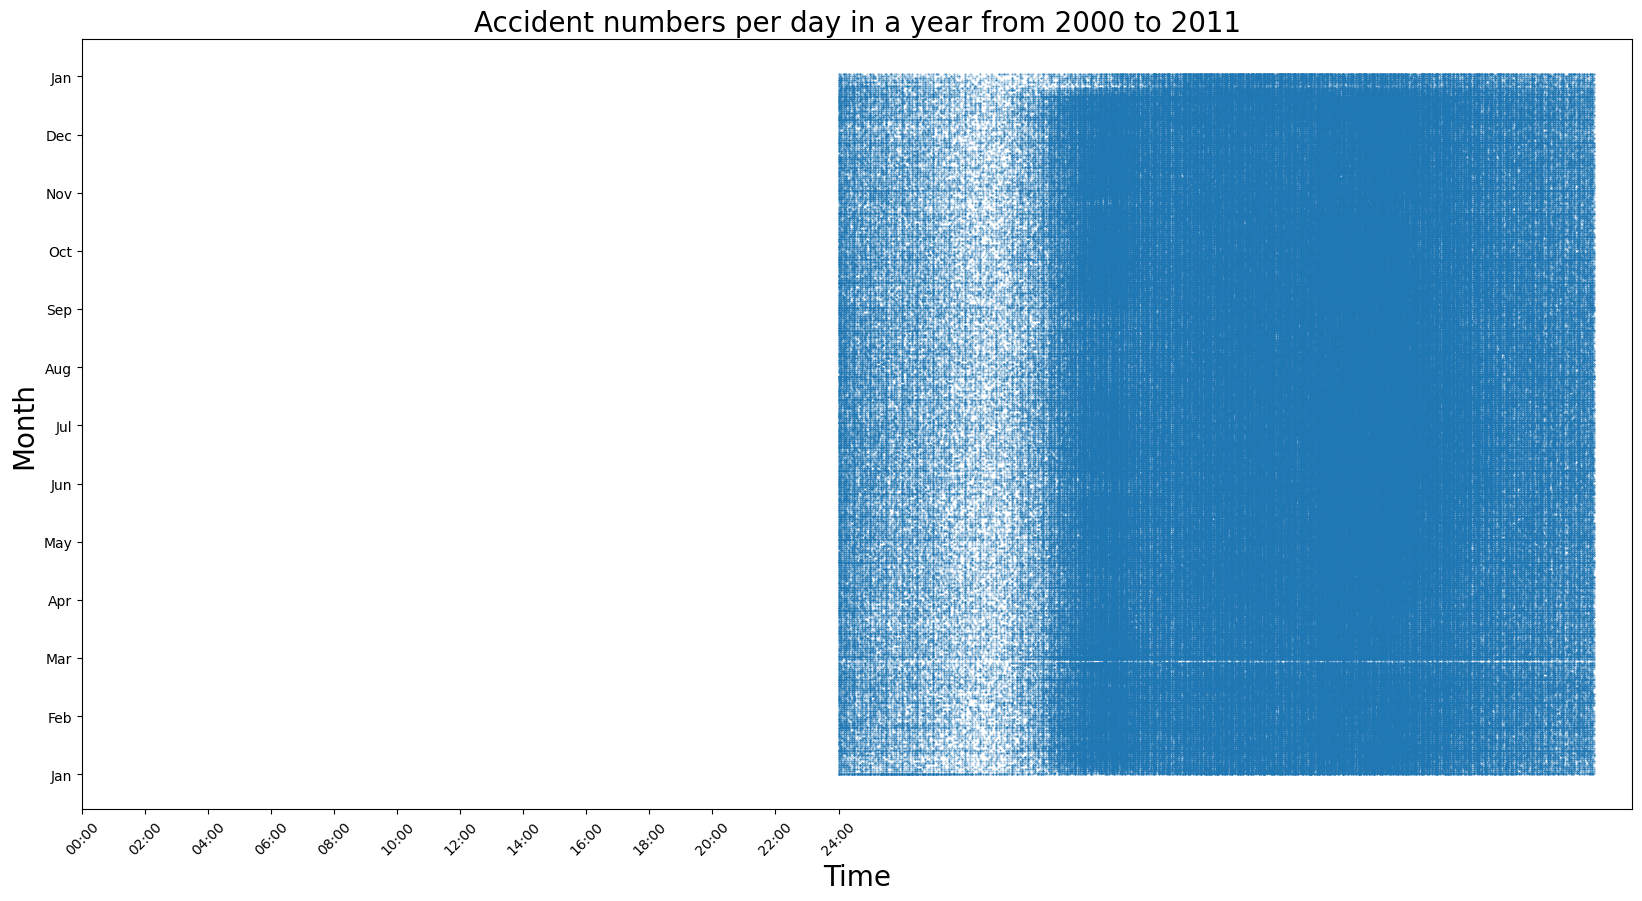

In [10]:
test_csv = csv.query("accident_year > 2000 & accident_year < 2011 & weather_conditions == 1 & local_authority_district != -1")[["time", "date"]].reset_index().drop(["index"],axis=1)

test_csv["time"] = pd.to_datetime(test_csv["time"])

test_csv[["date"]] = test_csv[["date"]].astype("string")
test_csv["date"] = test_csv["date"].map(lambda x: str(x)[3:-5]) + "-" + test_csv["date"].map(lambda x: str(x)[0:-8])
# test_csv

sort_csv = test_csv.sort_values(by=["date", "time"]).reset_index().drop(["index"],axis=1)
sort_csv.head()

x_ticks = np.linspace(19334, 19335, 13)
x_labels = ["00:00","02:00","04:00","06:00","08:00","10:00","12:00","14:00","16:00","18:00","20:00","22:00", "24:00"]

y_ticks = np.linspace(0, 364, 13)
y_labels = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec", "Jan"]

plt.figure(figsize=(20, 10), dpi=100)
plt.scatter(sort_csv["time"], sort_csv["date"].astype(str),s=1, marker=".", alpha=0.4,)
# set the style
plt.xlabel("Time", fontsize = 20)
plt.ylabel("Month", fontsize = 20)
plt.xticks(ticks=x_ticks, labels=x_labels, fontsize = 10, rotation = "45")
plt.yticks(ticks=y_ticks, labels=y_labels, fontsize = 10)
plt.title ("Accident numbers per day in a year from 2000 to 2011", fontsize = 20)

plt.show()

## Factors Area

Please define some factor we want to focus on and input them in lists.

(We can define the factor list to focus on some specific factors and clean the invalid data.)

PS: the length of "factor_list" and "invalid_value_list" should be coincident

PSS: use -999 if you do not want to filter anything

In [11]:
# the factor we want to concern
factor_list = ["light_conditions",  # Daylight-1    Darkness-4567
               "weather_conditions",  # Good-1,4    Bad-23567
               "road_surface_conditions",  # Good-1 Bad-234567
               "urban_or_rural_area"] # urban-1     rural-2
               

# invalid value in each factor - should be coinsident with factor factor_list
invalid_value_list = [[-1], 
                      [-1,8,9], 
                      [-1,9], 
                      [-1]]

# the factore need to be dropped when making the corelation matrix
dorp_list = [""]

# the year we want to focus, need input for a time period
time_range = ["2011", "2021"]

# define the factor list
# csv.columns

## Funtion

In [12]:
# plot the bar chart
def plot_bar(list, catag_boolen):
    x = list.iloc[:, 0]
    y = list.iloc[:, 1]
    if catag_boolen:
        for index in range(len(x)):
            x[index] = str(x[index])
    plt.bar(x, y)
    plt.show()

# get the accident number by factor name
def get_accident_number_by(value_string):
    try:
        sub_csv = sub_csv[[value_string]]
    except:
        print("the value you input is not valid")
        return
    count = sub_csv.groupby([value_string]).size().reset_index(name='counts')
    return count

# get_bar_by_factors
def get_bar_by_factors(factor, inCata):
    try:
        return plot_bar(get_accident_number_by(factor), inCata)
    except:
        print("please check the input")
        return 

## Data Processing Area

please do not change any code if it is not necessary

In [13]:
# make the query string
query_string = ""

for factor_index in range(len(factor_list)):
    for inva_index in range(len(invalid_value_list[factor_index])):
        factor_value = str(factor_list[factor_index])
        inva_value = str(invalid_value_list[factor_index][inva_index])
        query_string = query_string + factor_value +  " != " + inva_value
        if factor_index < len(factor_list):
            query_string = query_string + " & "


# add the year filter

query_string = query_string + "accident_year >= "  + time_range[0] + " & accident_year < " + time_range[1]


query_string

'light_conditions != -1 & weather_conditions != -1 & weather_conditions != 8 & weather_conditions != 9 & road_surface_conditions != -1 & road_surface_conditions != 9 & urban_or_rural_area != -1 & accident_year >= 2011 & accident_year < 2021'

In [14]:
# drop the invalid data and choose the year
csv_1 = csv.query(query_string)
# sub_csv = sub_csv.loc[(sub_csv["light_conditions"] != -1) & 
#                       (sub_csv["weather_conditions"] != -1) & 
#                       (sub_csv["weather_conditions"] != 8)& 
#                       (sub_csv["weather_conditions"] != 9)& 
#                       (sub_csv["road_surface_conditions"] != -1), ["light_conditions", "weather_conditions", "road_surface_conditions"]]
csv_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1261965 entries, 7282768 to 8602823
Data columns (total 36 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   accident_index                               1261965 non-null  object 
 1   accident_year                                1261965 non-null  int64  
 2   accident_reference                           1261965 non-null  object 
 3   location_easting_osgr                        1261826 non-null  float64
 4   location_northing_osgr                       1261826 non-null  float64
 5   longitude                                    1261816 non-null  float64
 6   latitude                                     1261816 non-null  float64
 7   police_force                                 1261965 non-null  int64  
 8   accident_severity                            1261965 non-null  int64  
 9   number_of_vehicles                      

In [15]:
csv_1.head()

,accident_index,accident_year,accident_reference,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,...,pedestrian_crossing_physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,trunk_road_flag,lsoa_of_accident_location
7282768,201101BS70001,2011,01BS70001,525590.0,178980.0,-0.192203,51.495766,1,3,1,...,0,4,2,2,0,0,1,1,2,E01002812
7282769,201101BS70002,2011,01BS70002,527450.0,179020.0,-0.165408,51.495710,1,2,2,...,0,4,1,2,0,0,1,1,2,E01002819
7282770,201101BS70003,2011,01BS70003,527120.0,178350.0,-0.170401,51.489763,1,3,1,...,0,4,1,1,0,0,1,1,2,E01002914
7282771,201101BS70005,2011,01BS70005,525400.0,179210.0,-0.194856,51.497875,1,3,2,...,0,4,1,1,0,0,1,1,2,E01002813
7282772,201101BS70007,2011,01BS70007,526280.0,177540.0,-0.182783,51.482671,1,3,2,...,0,4,1,2,0,0,1,2,2,E01002913


In [16]:
# get the feild by factors
sub_csv = csv_1[factor_list]

# reset the index to help the calculate
sub_csv = sub_csv.reset_index()[factor_list]

sub_csv

,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area
0,4,2,2,1
1,4,1,2,1
2,4,1,1,1
3,4,1,1,1
4,4,1,2,1
...,...,...,...,...
1261960,1,1,1,1
1261961,1,1,1,1
1261962,1,1,1,2
1261963,1,1,1,1


In [17]:
# reclassify the table

# ["light_conditions",            # Daylight-14    Darkness-4567
#  "weather_conditions",          # Good-1,4      Bad-23567
#  "road_surface_conditions",     # Good-1        Bad-234567
#  "urban_or_rural_area"]         # Urban-1       Rural-2,3

sub_csv.loc[sub_csv["light_conditions"].isin([1,4]), "light_conditions"] = 1
sub_csv.loc[sub_csv["light_conditions"].isin([5,6,7]), "light_conditions"] = 0

sub_csv.loc[sub_csv["weather_conditions"].isin([1,4]), "weather_conditions"] = 1
sub_csv.loc[sub_csv["weather_conditions"].isin([2,3,5,6,7]), "weather_conditions"] = 0

sub_csv.loc[sub_csv["road_surface_conditions"].isin([1]), "road_surface_conditions"] = 1
sub_csv.loc[sub_csv["road_surface_conditions"].isin([2,3,4,5,6,7]), "road_surface_conditions"] = 0

sub_csv.loc[sub_csv["urban_or_rural_area"].isin([1]), "urban_or_rural_area"] = 1
sub_csv.loc[sub_csv["urban_or_rural_area"].isin([2,3]), "urban_or_rural_area"] = 0

sub_csv.head()

,light_conditions,weather_conditions,road_surface_conditions,urban_or_rural_area
0,1,0,0,1
1,1,1,0,1
2,1,1,1,1
3,1,1,1,1
4,1,1,0,1


In [18]:
# calculate the cases number of each type
accident_count = sub_csv.groupby(factor_list).size().reset_index(name='accident_counts')
# accident_count.info()

In [19]:
# reform the df to do dummy
accident_count[factor_list] = accident_count[factor_list].astype(object)



# get dummy
accident_numeric = pd.get_dummies(accident_count)

# accident_numeric.info()

d:\anaconda3\lib\site-packages\pandas\core\algorithms.py:798: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  uniques = Index(uniques)


In [20]:
# drop some value 
# accident_final = accident_numeric.drop(dorp_list, axis=1)

accident_final = accident_numeric
# double check the result
accident_final.head()

,accident_counts,light_conditions_0,light_conditions_1,weather_conditions_0,weather_conditions_1,road_surface_conditions_0,road_surface_conditions_1,urban_or_rural_area_0,urban_or_rural_area_1
0,17610,1,0,1,0,1,0,1,0
1,4378,1,0,1,0,1,0,0,1
2,318,1,0,1,0,0,1,1,0
3,95,1,0,1,0,0,1,0,1
4,18936,1,0,0,1,1,0,1,0


In [21]:
# VIF calculating  function: drop_column_using_vif_(df, thresh=5)
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df


In [28]:
# using VIF on accident dataset
df_predictors_selected_VIF = drop_column_using_vif_(accident_final.drop('accident_counts', axis=1))
# print("The columns remaining after VIF selection are:")
# print(df_predictors_selected_VIF.columns)

Dropping: light_conditions_0
Dropping: weather_conditions_0
Dropping: road_surface_conditions_0
Dropping: urban_or_rural_area_0


d:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
d:\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
d:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
d:\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)
d:\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
d:\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_sc

,light_conditions_1,weather_conditions_1,road_surface_conditions_1,urban_or_rural_area_1
0,0,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,1
4,0,1,0,0


In [23]:
# build the model via VIF
model_accident = sm.OLS(endog=accident_final[['accident_counts']], exog=sm.add_constant(df_predictors_selected_VIF)).fit()

In [24]:
# Get the Correlation Matrix by df
def get_cm_by_df(df):
    plt.rcParams["axes.grid"] = False
    f = plt.figure(figsize=(19, 15))
    plt.matshow(df.corr(), fignum=f.number)
    plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
    plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title('Correlation Matrix', fontsize=16)

## Result Output Area

Here are results

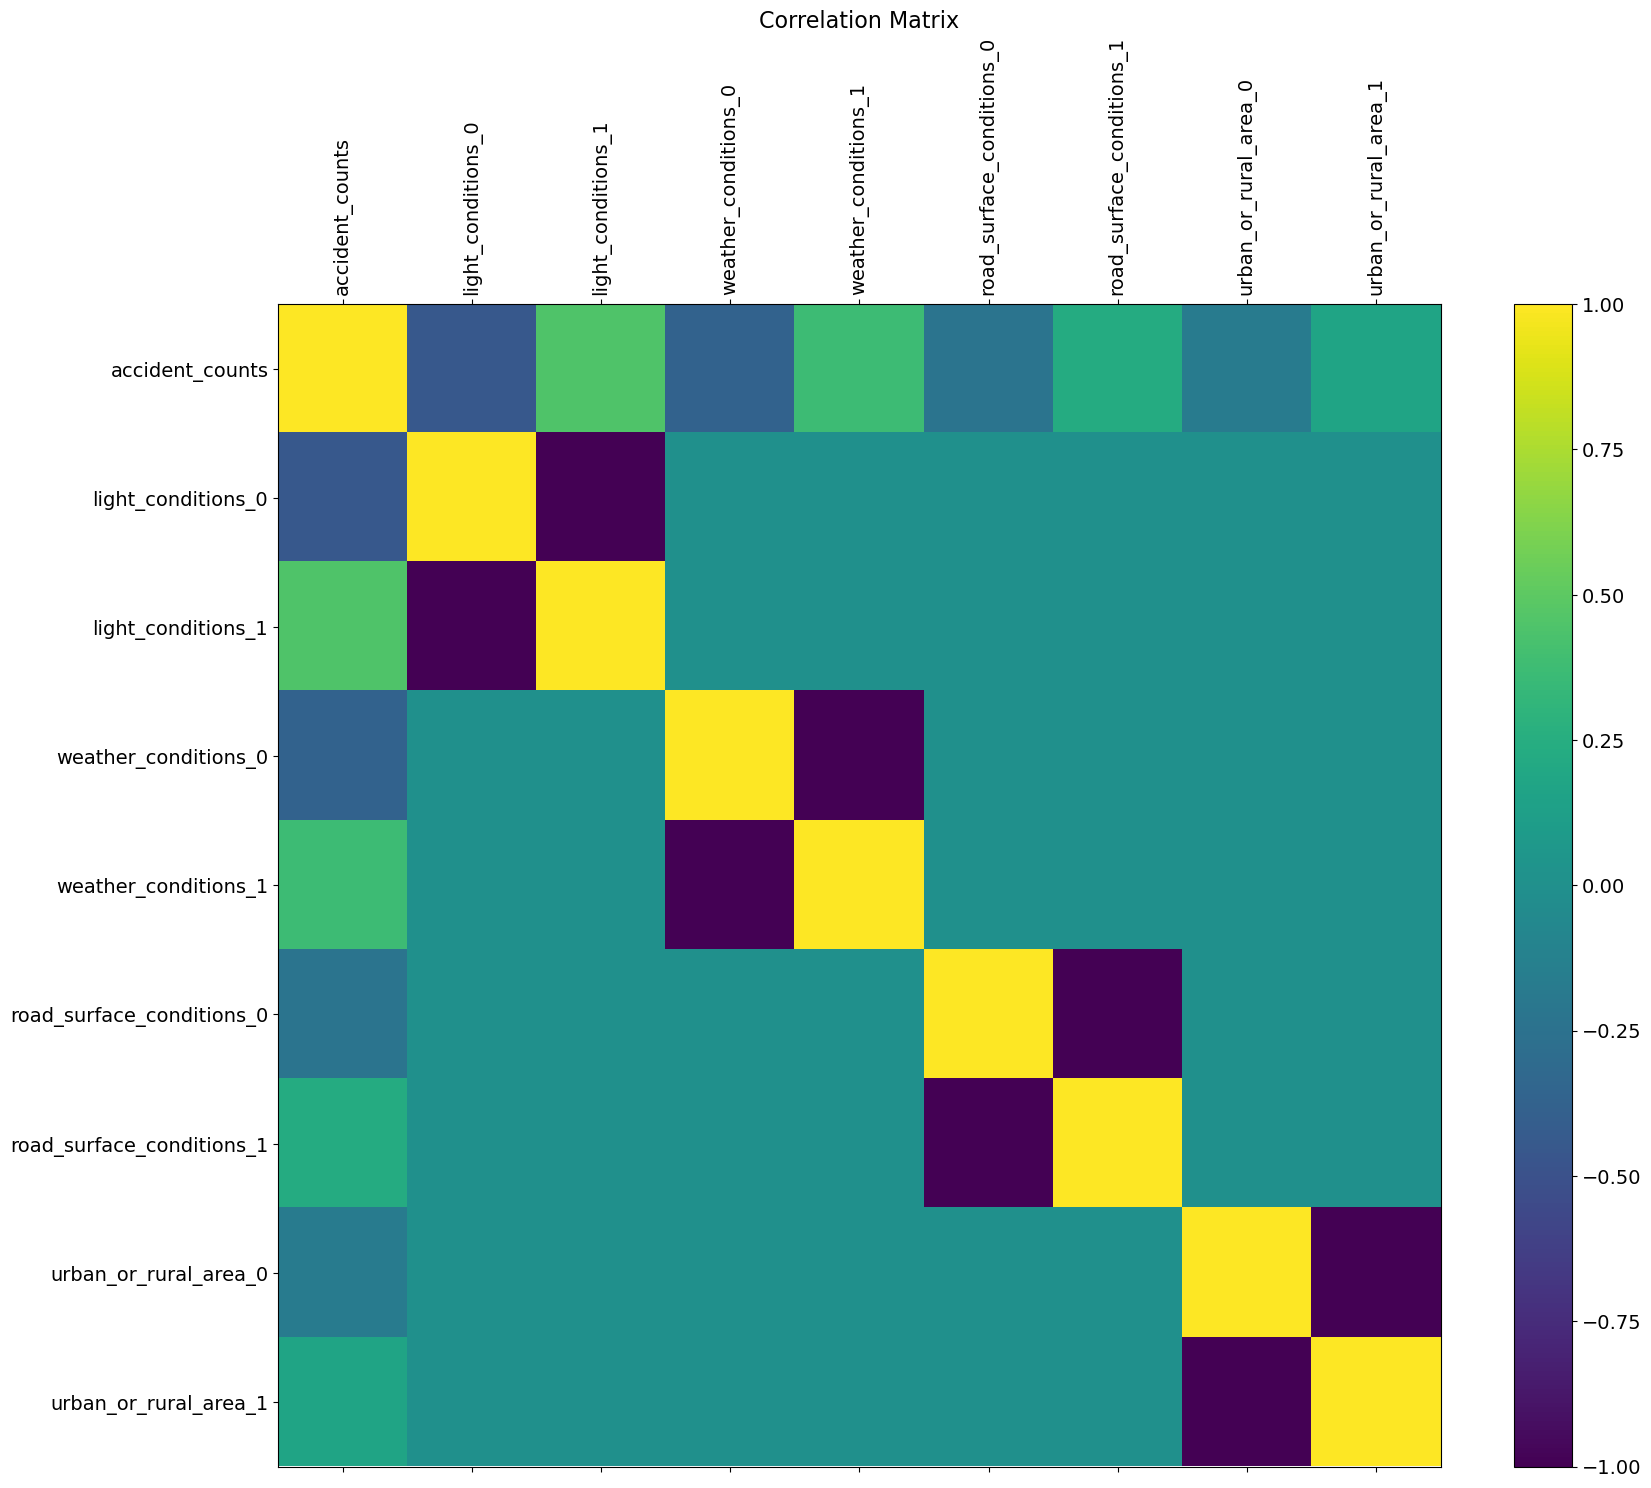

In [25]:
# the corelation matrix

# draw the correalation matrix
get_cm_by_df(accident_final)

In [26]:
time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())

'2022-12-09 23:33:39'

In [27]:
# the regression model
model_accident.summary()

d:\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:1769: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        accident_counts   R-squared:                       0.422
Model:                            OLS   Adj. R-squared:                  0.211
Method:                 Least Squares   F-statistic:                     2.004
Date:                Fri, 09 Dec 2022   Prob (F-statistic):              0.163
Time:                        23:33:39   Log-Likelihood:                -209.04
No. Observations:                  16   AIC:                             428.1
Df Residuals:                      11   BIC:                             431.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                     -1.042e+05    7.7e+04     -1.353      0.203   -2.74e+05    6.53e+04
light_conditions_1         1.352e+05   6.89e+04      1.962      0.076   -1.64e+04    2.87e+05
weather_conditions_1       1.118e+05   6.89e+04      1.623      0.133   -3.98e+04    2.63e+05
road_surface_conditions_1  6.914e+04   6.89e+04      1.004      0.337   -8.25e+04    2.21e+05
urban_or_rural_area_1      4.999e+04   6.89e+04      0.726      0.483   -1.02e+05    2.02e+05
==============================================================================
Omnibus:                       13.801   Durbin-Watson:                   0.816
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               10.936
Skew:                           1.515   Prob(JB):                      0.00422
Kurtosis:                       5.689   Cond. No.                         4.27
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""